In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [91]:
# Get the stock quote
df = yf.download('^GSPC', start = '1970-01-01', end='2021-01-15', progress = False)

In [101]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,92.059998,93.540001,91.790001,93.000000,93.000000,8050000
1970-01-05,93.000000,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,93.459999,93.809998,92.129997,92.820000,92.820000,11460000
1970-01-07,92.820000,93.379997,91.930000,92.629997,92.629997,10010000
1970-01-08,92.629997,93.470001,91.989998,92.680000,92.680000,10670000
...,...,...,...,...,...,...
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4764180000
2021-01-11,3803.139893,3817.860107,3789.020020,3799.610107,3799.610107,4450500000
2021-01-12,3801.620117,3810.780029,3776.510010,3801.189941,3801.189941,4977210000


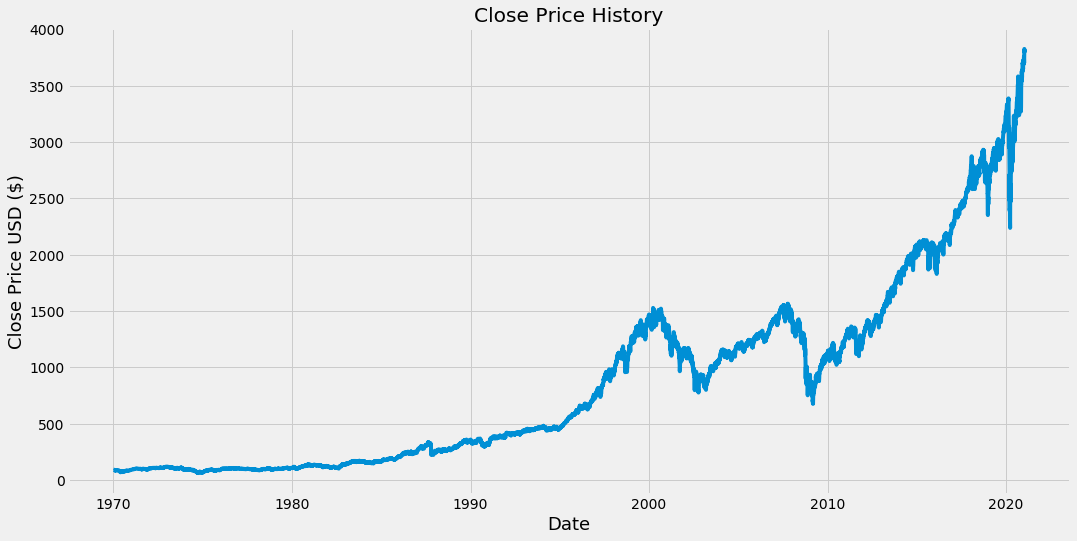

In [93]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [56]:
# # Create new dataframe with only the 'Close' column
# data = df.filter(['Close'])

In [57]:
# # Convert dataframe to numpy array
# dataset = data.values

In [102]:
import pandas as pd
import numpy as np
from pmdarima.arima import AutoARIMA
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from datetime import date, timedelta
import yfinance as yf

In [103]:
# Storing the dataframes in a dictionary
stock_df = {}
for col in set(df.columns.get_level_values(0)):
    
    # Assigning the data for each stock in the dictionary
    stock_df[col] = df[col]

In [104]:
stock_df

{'Open': Date
 1970-01-02      92.059998
 1970-01-05      93.000000
 1970-01-06      93.459999
 1970-01-07      92.820000
 1970-01-08      92.629997
                  ...     
 2021-01-08    3815.050049
 2021-01-11    3803.139893
 2021-01-12    3801.620117
 2021-01-13    3802.229980
 2021-01-14    3814.979980
 Name: Open, Length: 12875, dtype: float64,
 'Adj Close': Date
 1970-01-02      93.000000
 1970-01-05      93.459999
 1970-01-06      92.820000
 1970-01-07      92.629997
 1970-01-08      92.680000
                  ...     
 2021-01-08    3824.679932
 2021-01-11    3799.610107
 2021-01-12    3801.189941
 2021-01-13    3809.840088
 2021-01-14    3795.540039
 Name: Adj Close, Length: 12875, dtype: float64,
 'Volume': Date
 1970-01-02       8050000
 1970-01-05      11490000
 1970-01-06      11460000
 1970-01-07      10010000
 1970-01-08      10670000
                  ...    
 2021-01-08    4764180000
 2021-01-11    4450500000
 2021-01-12    4977210000
 2021-01-13    4590420000
 202

In [97]:
# Finding the log returns
stock_df['LogReturns'] = stock_df['Adj Close'].apply(np.log).diff().dropna()
# Using Moving averages
stock_df['MovAvg'] = stock_df['Adj Close'].rolling(10).mean().dropna()
# Logarithmic scaling of the data and rounding the result
stock_df['Log'] = stock_df['MovAvg'].apply(np.log).apply(lambda x: round(x, 2))

In [112]:
stock_df['Adj Close'].apply(np.log).diff().dropna()

Date
1970-01-05    0.004934
1970-01-06   -0.006871
1970-01-07   -0.002049
1970-01-08    0.000540
1970-01-09   -0.003026
                ...   
2021-01-08    0.005477
2021-01-11   -0.006576
2021-01-12    0.000416
2021-01-13    0.002273
2021-01-14   -0.003761
Name: Adj Close, Length: 12874, dtype: float64

In [105]:
# Days in the past to train on
days_to_train = 180 

# Days in the future to predict
days_to_predict = 5

# Establishing a new DF for predictions
stock_df['Predictions'] = pd.DataFrame(index=stock_df['Log'].index,
                                       columns=stock_df['Log'].columns)

# # Iterate through each stock
# for stock in tqdm(stocks):
    
#     # Current predicted value
#     pred_val = 0
    
#     # Training the model in a predetermined date range
#     for day in tqdm(range(1000, 
#                           stock_df['Log'].shape[0]-days_to_predict)):        

#         # Data to use, containing a specific amount of days
#         training = stock_df['Log'][stock].iloc[day-days_to_train:day+1].dropna()
        
#         # Determining if the actual value crossed the predicted value
#         cross = ((training[-1] >= pred_val >= training[-2]) or 
#                  (training[-1] <= pred_val <= training[-2]))
        
#         # Running the model when the latest training value crosses the predicted value or every other day 
#         if cross or day % 2 == 0:

#             # Finding the best parameters
#             model    = AutoARIMA(start_p=0, start_q=0,
#                                  start_P=0, start_Q=0,
#                                  max_p=8, max_q=8,
#                                  max_P=5, max_Q=5,
#                                  error_action='ignore',
#                                  information_criterion='bic',
#                                  suppress_warnings=True)

#             # Getting predictions for the optimum parameters by fitting to the training set            
#             forecast = model.fit_predict(training,
#                                          n_periods=days_to_predict)

#             # Getting the last predicted value from the next N days
#             stock_df['Predictions'][stock].iloc[day:day+days_to_predict] = np.exp(forecast[-1])


#             # Updating the current predicted value
#             pred_val = forecast[-1]

KeyError: 'Log'

In [21]:
# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * 0.8 )

training_data_len

10300

In [22]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(len(scaled_data))
scaled_data

12875


array([[0.008165  ],
       [0.00828726],
       [0.00811716],
       ...,
       [0.99375665],
       [0.99605575],
       [0.99225497]])

In [23]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

# Takes the first 60 values for x train and y train is the 61st value
for i in range(60 , len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.008165  , 0.00828726, 0.00811716, 0.00806666, 0.00807995,
       0.00800553, 0.00781948, 0.00787795, 0.00780619, 0.00781416,
       0.00761216, 0.00727461, 0.00732245, 0.00735435, 0.00737827,
       0.00720019, 0.00688125, 0.00673506, 0.00651446, 0.00622209,
       0.00604401, 0.00623804, 0.00650914, 0.00636828, 0.00627791,
       0.0063922 , 0.00657293, 0.00633107, 0.00655433, 0.00649851,
       0.00644801, 0.00642941, 0.00640283, 0.00668722, 0.00677227,
       0.00684404, 0.0068334 , 0.00719488, 0.00707527, 0.00723474,
       0.00729056, 0.00742877, 0.00737827, 0.00736764, 0.0072188 ,
       0.00697161, 0.0070354 , 0.00701946, 0.00692377, 0.00679885,
       0.00654635, 0.00664735, 0.0067138 , 0.00668191, 0.00658622,
       0.00656762, 0.00683075, 0.00730651, 0.00734637, 0.0072693 ])]
[0.007269295918076752]



In [24]:
# Convert x_train and y_train to numpy arrays to train LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
# Reshape the data because LSTM takes input as 3D and our data is in 2D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(10240, 60, 1)

In [75]:
x_train.shape

(10240, 60, 1)

In [138]:
# give best model loop
rmse = 10
while rmse > 0.5:
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape= (x_train.shape[1], 1)))
    #     model.add(LSTM(50, return_sequences=False))
    #     model.add(Dense(25))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=250, epochs=10)
    # Create the testing data set
    # Create a new array containing scaled values from 552-60 to 765
    test_data = scaled_data[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt( np.mean( predictions - y_test )**2 )
    print(rmse)


Epoch 1/10
41/41 [==============================] - 3s 38ms/step - loss: 0.0119
Epoch 2/10
41/41 [==============================] - 2s 39ms/step - loss: 6.1607e-05
Epoch 3/10
41/41 [==============================] - 2s 39ms/step - loss: 1.7860e-05
Epoch 4/10
41/41 [==============================] - 2s 39ms/step - loss: 1.5355e-05
Epoch 5/10
41/41 [==============================] - 2s 39ms/step - loss: 1.3903e-05
Epoch 6/10
41/41 [==============================] - 2s 39ms/step - loss: 1.5278e-05
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 1.3978e-05
Epoch 8/10
41/41 [==============================] - 2s 39ms/step - loss: 1.3643e-05
Epoch 9/10
41/41 [==============================] - 2s 39ms/step - loss: 1.2830e-05
Epoch 10/10
41/41 [==============================] - 2s 39ms/step - loss: 1.2460e-05
4.407395612105582
Epoch 1/10
41/41 [==============================] - 3s 45ms/step - loss: 0.0074
Epoch 2/10
41/41 [==============================] - 2s 45ms/step 

### TEST

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

10241/10241 [==============================] - 159s 15ms/step - loss: 1.7590e-04


In [34]:
# Create the testing data set
# Create a new array containing scaled values from 552-60 to 765
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [35]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [42]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [37]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [27]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

3.6224580457372575

### TEST

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


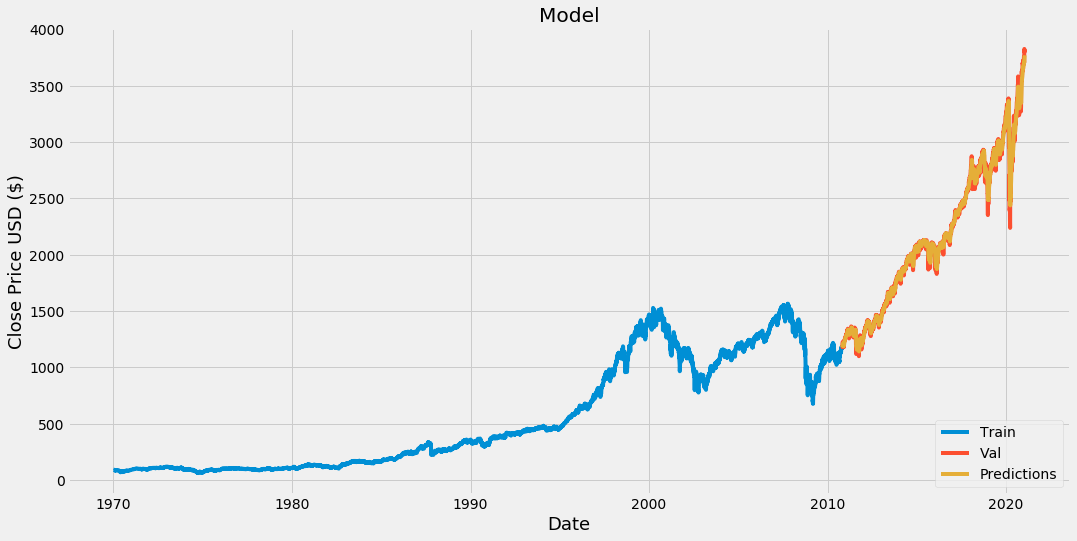

In [139]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [140]:
# Show the valid and the predicted prices
valid['RMSE'] = (valid['Predictions'] - valid['Close'])**2
valid['Variance %'] = ((valid['Close'] - valid['Predictions'])/valid['Close']) * 100
valid

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,Predictions,RMSE,Variance %
Date,,,,
2010-10-22,1183.079956,1176.040283,49.556994,0.595029
2010-10-25,1185.619995,1177.922852,59.246019,0.649208
2010-10-26,1185.640015,1179.939209,32.499185,0.480821
2010-10-27,1182.449951,1181.618042,0.692073,0.070355
2010-10-28,1183.780029,1182.410889,1.874546,0.115658
...,...,...,...,...
2021-01-08,3824.679932,3727.384033,9466.491853,2.543896
2021-01-11,3799.610107,3743.355957,3164.529436,1.480524
2021-01-12,3801.189941,3752.605713,2360.427260,1.278132


In [141]:
# Get the quote
df1 = yf.download('^GSPC', start = '2021-01-15', end='2021-01-16', progress = False)
df1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-15,3788.72998,3788.72998,3749.620117,3768.25,3768.25,5353060000


In [142]:
# Get the quote
new_df = df.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)
print(pred_price[0][0])

3772.0977


In [143]:
print(f"Actual Closing Price ($): {round(df1['Close'][0],1)}")
print(f"Predicted Closing Price ($): {round(pred_price[0][0],1)}")
print(f"Variance: {round(((pred_price[0][0] - df1['Close'][0]) / pred_price[0][0])*100, 2)} %")

Actual Closing Price ($): 3768.2
Predicted Closing Price ($): 3772.10009765625
Variance: 0.1 %


In [144]:
# Make predictions on the next 30 days
for i in range(90):

  if i == 0:
    new_df = df.filter(['Close'])

    last_60_days = new_df[-60:].values

    last_60_days_scaled = scaler.transform(last_60_days)

    X_test = []

    X_test.append(last_60_days_scaled)

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)

    pred_price = scaler.inverse_transform(pred_price)

    pred_price = pred_price[0][0]

    new_df = new_df.append({'Close': pred_price}, ignore_index=True)
  else:
    new_df = new_df.filter(['Close'])

    last_60_days = new_df[-60:].values

    last_60_days_scaled = scaler.transform(last_60_days)

    X_test = []

    X_test.append(last_60_days_scaled)

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred_price = model.predict(X_test)

    pred_price = scaler.inverse_transform(pred_price)

    pred_price = pred_price[0][0]

    new_df = new_df.append({'Close': pred_price}, ignore_index=True)

new_df

,Close
0,93.000000
1,93.459999
2,92.820000
3,92.629997
4,92.680000
...,...
12960,3553.229248
12961,3551.264404
12962,3549.313477
12963,3547.373779


In [145]:
new_df[12879:]

,Close
12879,3764.055908
12880,3761.281982
12881,3758.365479
12882,3755.350586
12883,3752.270020
...,...
12960,3553.229248
12961,3551.264404
12962,3549.313477
12963,3547.373779


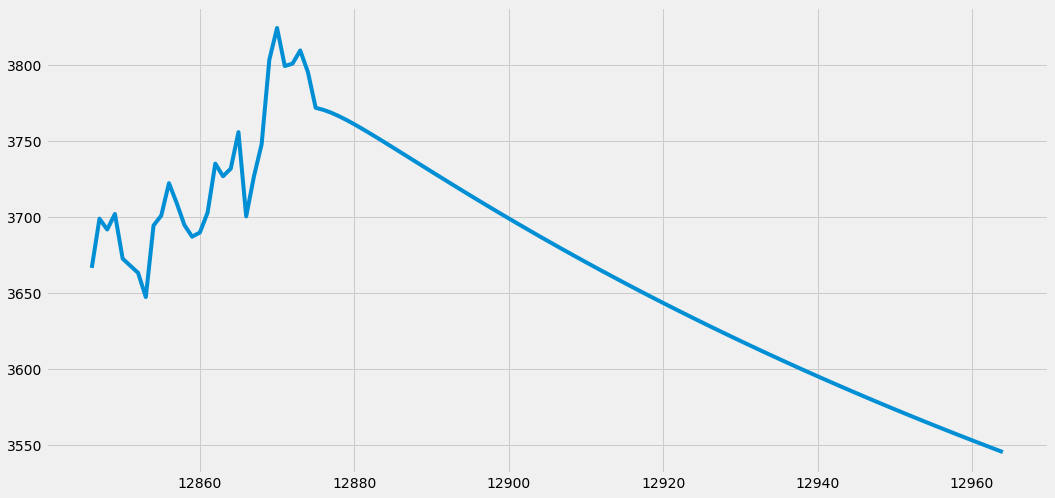

In [146]:
plt.figure(figsize=(16,8))
plt.plot(new_df[12846:])

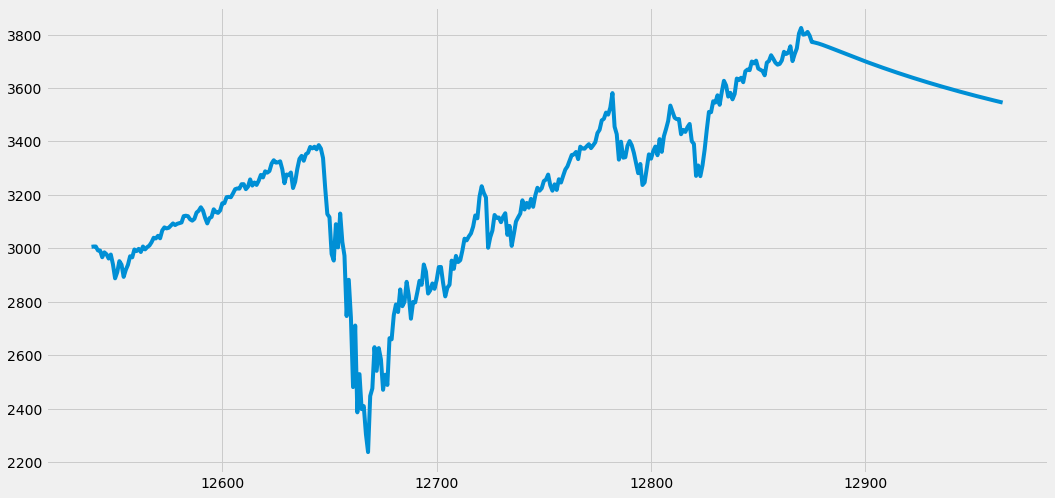

In [147]:
plt.figure(figsize=(16,8))
plt.plot(new_df[12539:])

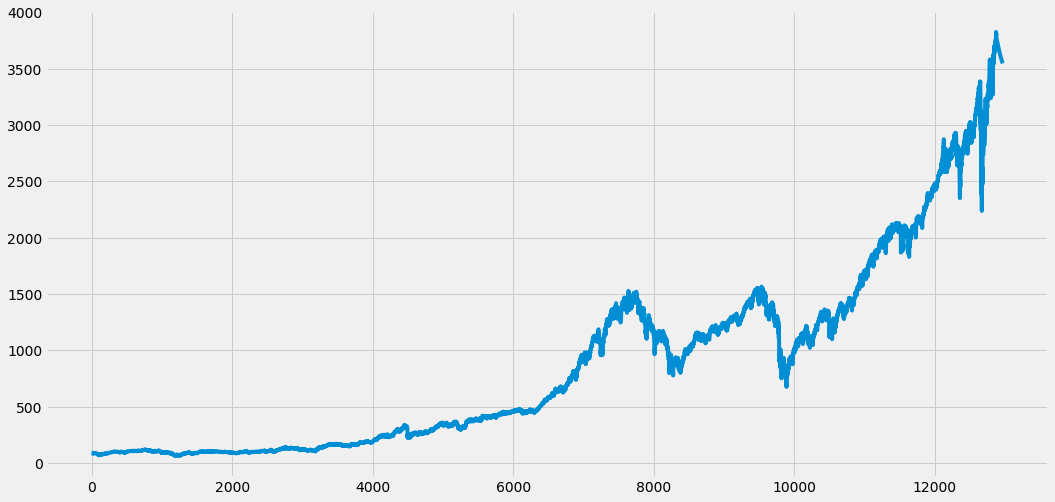

In [148]:
plt.figure(figsize=(16,8))
plt.plot(new_df)